We're testing Gemini's Argo data loading code here.

In [5]:
import numpy as np
import argopy
from argopy import DataFetcher
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from datetime import datetime
from cartopy.geodesic import Geodesic
from scipy import linalg
#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics.pairwise import haversine_distances
from matplotlib.patches import Circle


In [3]:
# --- SECTION 1: CONFIGURATION ---
# Define the "Arena" for the California Current
# Format: [lon_min, lon_max, lat_min, lat_max, depth_min, depth_max]
# We look at 0-600m depth to capture the subsurface signal and a bit of the deeper ocean signal
# We restrict longitude to -126 to -120 to
#  stay close to the coast.

depth = 1000 #m
region_box = [-126, -120, 30, 40, 0, depth]

In [6]:
# Define the Time Window
# We'll look at the last couple years for this test run.
start_date = '2022-01-01'
end_date = '2024-12-31'

print(f"🌊 Setting up query for California Current: {region_box}")
print(f"📅 Timeframe: {start_date} to {end_date}")

🌊 Setting up query for California Current: [-126, -120, 30, 40, 0, 1000]
📅 Timeframe: 2022-01-01 to 2024-12-31


In [7]:
# --- SECTION 2: FETCHING THE INDEX (METADATA) ---
# We use the 'erddap' source as it's often faster for regional queries.
# We fetch the 'index' first, not the data. This returns a Pandas DataFrame of LOCATIONS.

# REQUIRES numpy<2.0 BECAUSE OF HOW XARRAY, PANDAS, AND ARGOPY HANDLE ARGO DATA
try:
    loader = DataFetcher(src='erddap')
    
    # .float() selects Argo floats
    # .region() sets the box and time
    # .to_index() grabs just the metadata (lat/lon/time), not the heavy sensor data
    index_df = loader.region(region_box + [start_date, end_date]).to_index()
    
    print(f"✅ Success! Found {len(index_df)} profiles in this region.")
    
except Exception as e:
    print(f"❌ Error fetching data: {e}")
    # Common error: ERDDAP might be busy. Retry or check internet.
    index_df = None

✅ Success! Found 1695 profiles in this region.


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


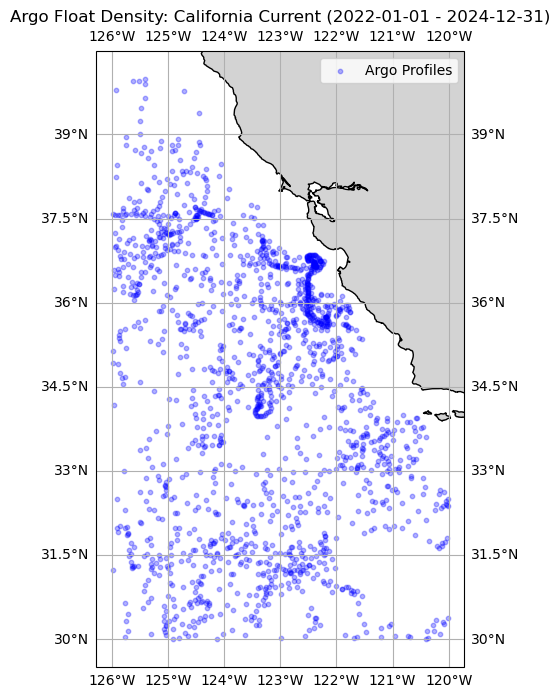

In [8]:
# --- SECTION 3: VISUALIZATION (THE MAP) ---
if index_df is not None:
    fig = plt.figure(figsize=(10, 8))
    
    # Use PlateCarree projection (standard lat/lon)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add land features so we can see the coast
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    
    # Plot the profiles
    # We use 'alpha=0.3' to make points semi-transparent. 
    # Darker areas = More data (Good for statistics!)
    sc = ax.scatter(index_df['longitude'], index_df['latitude'], 
                    s=10, c='blue', alpha=0.3, transform=ccrs.PlateCarree(),
                    label='Argo Profiles')
    
    # Formatting
    ax.set_title(f"Argo Float Density: California Current ({start_date} - {end_date})")
    ax.gridlines(draw_labels=True)
    plt.legend()
    
    # Save the map to check it
    plt.savefig('california_argo_scout.png')
    plt.show()
    
    #print("🗺️ Map generated. Check 'california_argo_scout_23to24.png'")

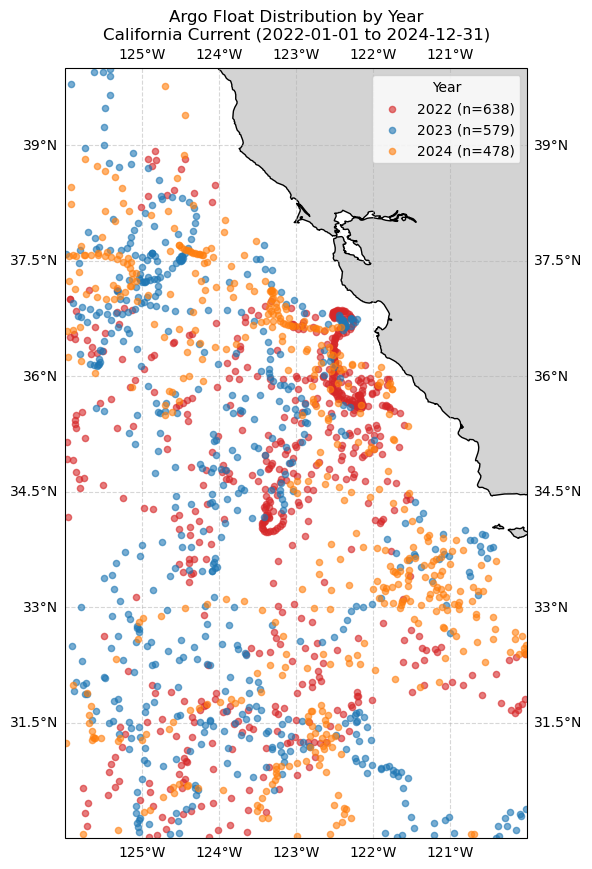

In [9]:
#HERE'S THE PLOT ABOVE, BUT NOW WE SEE DIFFERENT COLORS FOR EACH YEAR
if index_df is not None:
    # Ensure date column is datetime objects
    index_df['date'] = pd.to_datetime(index_df['date'])
    
    # Extract the Year for coloring
    index_df['Year'] = index_df['date'].dt.year

    # --- SECTION 3: THE PLOT ---
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # 1. Map Features
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=1, zorder=1)
    ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

    # 2. Define Color Map (Manual control for clarity)
    # You can add more years if needed
    #
    # MAKE THIS AUTOMATIC
    #
    color_map = {
        2020: 'cyan',
        2021: 'tab:purple',
        2022: 'tab:red',
        2023: 'tab:blue',
        2024: 'tab:orange', 
        2025: 'tab:green'
    }

    # 3. Loop through years and plot
    # Grouping allows us to create a clean Legend automatically
    for year, group in index_df.groupby('Year'):
        color = color_map.get(year, 'black') # Default to black if year not in map
        
        ax.scatter(group['longitude'], group['latitude'], 
                   s=20,                 # Size of dots
                   c=color,              # Color based on year
                   alpha=0.6,            # Transparency (helps see density)
                   transform=ccrs.PlateCarree(), 
                   label=f"{year} (n={len(group)})",
                   zorder=2)

    # 4. Final Formatting
    ax.set_title(f"Argo Float Distribution by Year\nCalifornia Current ({start_date} to {end_date})")
    ax.set_extent(region_box[:4]) # Zoom to the box
    plt.legend(loc='upper right', title="Year")
    
    # Save it
    #plt.savefig('california_argo_scout_23to25.png', dpi=150)
    plt.show()

In [10]:
# Quick Check: How many unique floats?
# Argo floats have unique WMO IDs.
unique_floats = index_df['wmo'].nunique()
print(f"🤖 Total unique floats found: {unique_floats}")

if unique_floats < 5:
    print("⚠️ Warning: Low float count. We might need to expand the box slightly offshore.")
else:
    print("🚀 Status: Good data density for analysis.")

🤖 Total unique floats found: 27
🚀 Status: Good data density for analysis.


In [11]:
print("⬇️ Initializing Argo Download... (This may take 1-5 minutes)")

# --- SECTION 4: THE DOWNLOAD ---
# We use standard mode. 
# 'expert' mode gives more control, but 'standard' handles QC automatically.
try:
    fetcher = DataFetcher(src='erddap', mode='standard')
    
    # Request the data
    # This pulls Temperature (TEMP) and Pressure (PRES) by default
    ds_raw = fetcher.region(region_box + [start_date, end_date]).to_xarray()
    
    print("✅ Download Complete!")
    print(f"📦 Raw Data Shape: {ds_raw.dims}")

except Exception as e:
    print(f"❌ Download Failed: {e}")
    ds_raw = None

# --- SECTION 5: TRANSFORMATION & INTERPOLATION ---
if ds_raw is not None:
    print("🔄 Processing: Converting 'Points' to 'Profiles'...")
    
    # 1. Organizing: Group the messy points into distinct profiles
    # This transforms the data from a long list of points to a matrix of [N_profiles, N_levels]
    ds_profiles = ds_raw.argo.point2profile()
    
    # 2. Interpolation: We need a standard depth ruler for OHC calculation.
    # We will interpolate data to every 5 meters from 0 to 500m.
    print("📏 Interpolating to standard levels (0-600m @ 5m steps)...")
    
    # Define standard depth levels
    std_levels = np.arange(0, depth, 5) 
    
    # Argopy has a handy tool for this, but xarray interpolation is robust.
    # We interpolate the 'TEMP' variable along the 'PRES' dimension.
    ds_interp = ds_profiles.argo.interp_std_levels(std_levels)
    
    # --- SECTION 6: CLEANING & SAVING ---
    # We only need Temperature, Time, Latitude, Longitude for OHC
    # Dropping extra variables saves disk space.
    final_ds = ds_interp[['TEMP']]
    
    print("💾 Saving to NetCDF...")
    filename = 'california_current_argo_2022_2024.nc'
    final_ds.to_netcdf(filename)
    print(f"🎉 Success! Data saved to: {filename}")

 

⬇️ Initializing Argo Download... (This may take 1-5 minutes)
✅ Download Complete!
📦 Raw Data Shape: FrozenMappingWarningOnValuesAccess({'N_POINTS': 828206})
🔄 Processing: Converting 'Points' to 'Profiles'...
📏 Interpolating to standard levels (0-600m @ 5m steps)...
💾 Saving to NetCDF...
🎉 Success! Data saved to: california_current_argo_2022_2024.nc


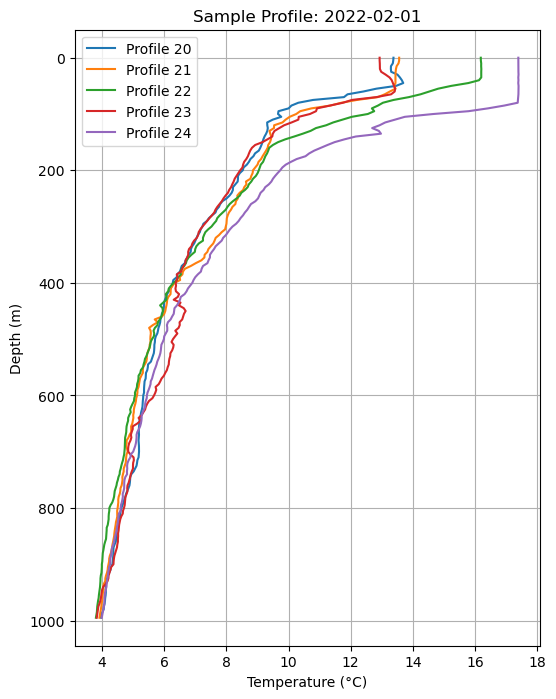

📊 Dataset Info:
<xarray.Dataset> Size: 1MB
Dimensions:            (N_PROF: 1559, PRES_INTERPOLATED: 200)
Coordinates:
    LATITUDE           (N_PROF) float64 12kB 31.44 35.36 31.39 ... 35.05 35.94
    LONGITUDE          (N_PROF) float64 12kB -125.3 -125.1 ... -122.0 -124.2
    TIME               (N_PROF) datetime64[ns] 12kB 2022-01-03T06:08:53 ... 2...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 2kB 0 5 10 15 ... 985 990 995
  * N_PROF             (N_PROF) int64 12kB 32 1369 419 549 ... 1141 31 1039 1200
Data variables:
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 1MB 16.49 ... 3.774
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           avik2007
    Fetched_date:         2026/01/09
    Fetched_constraints:  [x=-126.00/-120.00; y=30.00/40.00; z=0.0/1000.0; t=...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Processin

In [12]:
   # --- SECTION 7: VISUAL CHECK ---
    # Let's plot the first profile to make sure it looks like an ocean.
   plt.figure(figsize=(6, 8))
   
   # Select the first profile (isel selects by index)
   for j in range(20,25):
      sample = final_ds.isel(N_PROF=j)
   
      plt.plot(sample['TEMP'], sample['PRES_INTERPOLATED'], label='Profile ' + str(j))
   plt.gca().invert_yaxis() # Oceanography standard: Surface (0) is at top
   plt.grid(True)
   plt.title(f"Sample Profile: {str(sample['TIME'].values)[:10]}")
   plt.xlabel("Temperature (°C)")
   plt.ylabel("Depth (m)")
   plt.legend()
   plt.show()

   print(f"📊 Dataset Info:\n{final_ds}")

In [ ]:
# Now, we're ready to start calculating ocean heat content
# first, we need to incorporate the ocean equation of state, to get salinity, density, and conservative temperature
# import gsw (added this above)

In [13]:
# we need a function to calculate the density/salinity/temperature and incorporate it into our
# xarray structures

# --- HELPER FUNCTION FOR APPLY_UFUNC ---
def calculate_thermodynamics(sp, t, p, lon, lat):
    """
    Wrapper for GSW functions to be used with apply_ufunc.
    Inputs are expected to be numpy arrays (handled by xarray wrapper).
    """
    # 1. Absolute Salinity (SA)
    # GSW requires (SP, P, lon, lat)
    # We ensure P is broadcasted correctly by xarray before it gets here
    sa = gsw.SA_from_SP(sp, p, lon, lat)
    
    # 2. Conservative Temperature (CT)
    ct = gsw.CT_from_t(sa, t, p)
    
    # 3. Density (rho)
    rho = gsw.rho(sa, ct, p)
    
    # 4. Specific Heat Capacity (Cp)
    cp = gsw.cp_t_exact(sa, t, p)
    
    # 5. Energy Density (J/m^3) = rho * cp * T (in-situ)
    # We return the energy density directly
    return rho * cp * t

# once we have the ability to calculate thermodynamics for one ocean column, we can incorporate it into 
# a function that makes xarray inputs/outputs
def compute_ohc_layer(ds_input, layer_label):
    # Ensure inputs are present
    # Salinity sensors can be fouled up in Argo sensors, so we have to account for this possibility
    if 'PSAL' not in ds_input or 'TEMP' not in ds_input:
        print(f"⚠️ Missing variables in {layer_label}")
        return None

    # GSW needs Lat/Lon as arguments. 
    # ds_input['LONGITUDE'] and ['LATITUDE'] are likely 1D (by profile).
    # We don't need to manually broadcast them; apply_ufunc handles alignment 
    # if we pass them as xarray objects.
    
    # However, PRESSURE is a vertical coordinate (PRES_INTERPOLATED).
    # We must ensure it's passed correctly.
    
    # THE WRAPPER:
    # We use apply_ufunc to push the xarray objects into the numpy-based GSW function
    energy_density = xr.apply_ufunc(
        calculate_thermodynamics,
        ds_input['PSAL'],
        ds_input['TEMP'],
        ds_input['PRES_INTERPOLATED'],
        ds_input['LONGITUDE'],
        ds_input['LATITUDE'],
        input_core_dims=[[], [], [], [], []], # All inputs map point-to-point (broadcasting happens auto)
        output_core_dims=[[]], # Returns one array of same shape
        vectorize=True,        # Loops if core dims don't match (safe fallback)
        dask='parallelized',   # If you use Dask chunks later, this is ready
        output_dtypes=[float]
    )
    
    # 2. Integrate over depth (J/m^3 -> J/m^2)
    ohc = energy_density.integrate(coord='PRES_INTERPOLATED')
    
    # 3. Metadata
    ohc.name = layer_label
    ohc.attrs['units'] = 'J/m^2'
    ohc.attrs['description'] = 'Integrated Heat Content (TEOS-10: Rho*Cp*T)'
    
    return ohc


# --- TIME SERIES RESAMPLING ---
# we convert the xarray ocean heat content structure into a pandas structure. We then resample to look
# monthly mean trends. This function takes all the floats in the region we picked (no matter what the
# size, and lumps their data together, creating a terribly spatially averaged heat content, subject
# to biases in a region that may have heterogeneous heat content (north south bias, for example))
def make_timeseries(da_ohc):
    if da_ohc is None: return None
    df = da_ohc.to_dataframe().reset_index()
    df = df.set_index('TIME')
    # Resample to Monthly Mean
    return df[da_ohc.name].resample('MS').mean()

# this 
def make_spatially_weighted_timeseries(da_ohc):
    # 1. Convert to DataFrame
    df = da_ohc.to_dataframe().reset_index()
    
    # 2. Create Spatial Bins (e.g., 1-degree bins)
    # We round the Lat/Lon to the nearest integer to create "bins"
    """
     UPDATE THIS TO ALLOW FOR BINS OF ANY SIZE. 1 DEGREE COULD BE TOO SMALL 
    """
    df['lat_bin'] = df['LATITUDE'].round(0)
    df['lon_bin'] = df['LONGITUDE'].round(0)
    
    # 3. Create Time Bins (Month)
    # We use a string format for grouping: "2023-01"
    df['month_year'] = df['TIME'].dt.to_period('M')
    
    # --- THE TRICK ---
    # Step A: Average inside each 1x1 degree bin for each month
    # This collapses the 50 offshore floats into a single "grid value"
    grid_means = df.groupby(['month_year', 'lat_bin', 'lon_bin'])[da_ohc.name].mean().reset_index()
    
    # Step B: Average the grid cells for each month
    # Now every grid cell gets an equal vote, regardless of how many floats were in it
    regional_means = grid_means.groupby('month_year')[da_ohc.name].mean()
    
    # Convert index back to Timestamp for plotting
    regional_means.index = regional_means.index.to_timestamp()
    
    return regional_means

In [14]:
# NOTE TO SELF - MAKE A FUNCTION THAT COUNTS THE RESULTANT OHC AND FINDS 
# HOW MANY ARGO FLOATS WERE "BIOFOULED"

In [15]:
# --- CONFIGURATION ---
# We need to broadcast Lat/Lon to match the shape of the data for GSW
# (GSW needs a lat/lon for every pixel to calculate gravity correctly)
print("🧮 Preparing TEOS-10 Thermodynamics via apply_ufunc...")


#we're going to study a top layer (100m), which we call the surface, shallow or response layer
# we study a "source layer" (150-400m), and finally a background layer (500-1000m)
response_layer_bottom = 100
source_layer_top = 150
source_layer_bottom = 400
background_layer_top = 500
background_layer_bottom = depth

# 1. Create data layers
ds_shallow = ds_interp.sel(PRES_INTERPOLATED=slice(0, response_layer_bottom))
ds_deep    = ds_interp.sel(PRES_INTERPOLATED=slice(source_layer_top, source_layer_bottom))
ds_background = ds_interp.sel(PRES_INTERPOLATED=slice(background_layer_top, background_layer_bottom))

# --- EXECUTION ----
# 2. calculate their ocean heat content
ohc_shallow_ts = compute_ohc_layer(ds_shallow, 'OHC_Shallow')
ohc_deep_ts    = compute_ohc_layer(ds_deep, 'OHC_Deep')
ohc_background_ts   = compute_ohc_layer(ds_background, 'OHC_Background')


#---- MAKE A TIME SERIES -----
ts_shallow_NONBIN = make_timeseries(ohc_shallow_ts)
ts_deep_NONBIN    = make_timeseries(ohc_deep_ts)
ts_background_NONBIN = make_timeseries(ohc_background_ts)
ts_shallow = make_spatially_weighted_timeseries(ohc_shallow_ts)
ts_deep = make_spatially_weighted_timeseries(ohc_deep_ts)
ts_background = make_spatially_weighted_timeseries(ohc_background_ts)

🧮 Preparing TEOS-10 Thermodynamics via apply_ufunc...


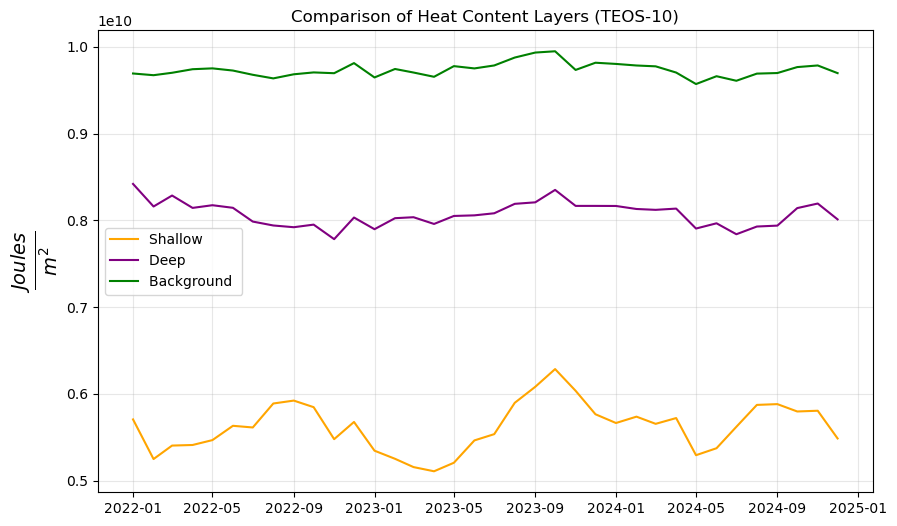

In [16]:
# Quick sanity check plot
plt.figure(figsize=(10, 6))
plt.plot(ts_shallow.index, ts_shallow.values, label='Shallow ', color='orange')
plt.plot(ts_deep.index, ts_deep.values, label='Deep ', color='purple')
plt.plot(ts_background.index, ts_background.values, label ='Background ', color='green')
plt.title("Comparison of Heat Content Layers (TEOS-10)")
plt.ylabel(r"$\frac{Joules}{m^2}$", fontsize=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save them
#ts_shallow.to_csv('CCS_OHC_Shallow_GSW.csv')
#ts_deep.to_csv('CCS_OHC_Deep_GSW.csv')
# Save them
#ts_shallow.to_csv('CCS_OHC_Shallow_GSW.csv')
#ts_deep.to_csv('CCS_OHC_Deep_GSW.csv')

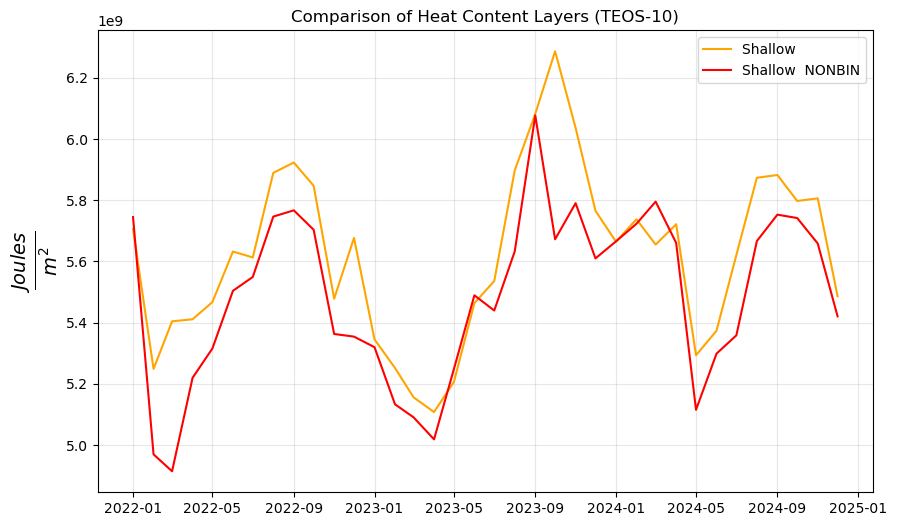

In [17]:
# Quick sanity check plot for shallow, binned vs nonbinned
plt.figure(figsize=(10, 6))
plt.plot(ts_shallow.index, ts_shallow.values, label='Shallow ', color='orange')
#plt.plot(ts_deep.index, ts_deep.values, label='Deep ', color='purple')
plt.plot(ts_shallow_NONBIN.index, ts_shallow_NONBIN.values, label='Shallow  NONBIN', color='red')
#plt.plot(ts_deep_NONBIN.index, ts_deep_NONBIN.values, label='Deep  NONBIN', color='green')
plt.title("Comparison of Heat Content Layers (TEOS-10)")
plt.ylabel(r"$\frac{Joules}{m^2}$", fontsize=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


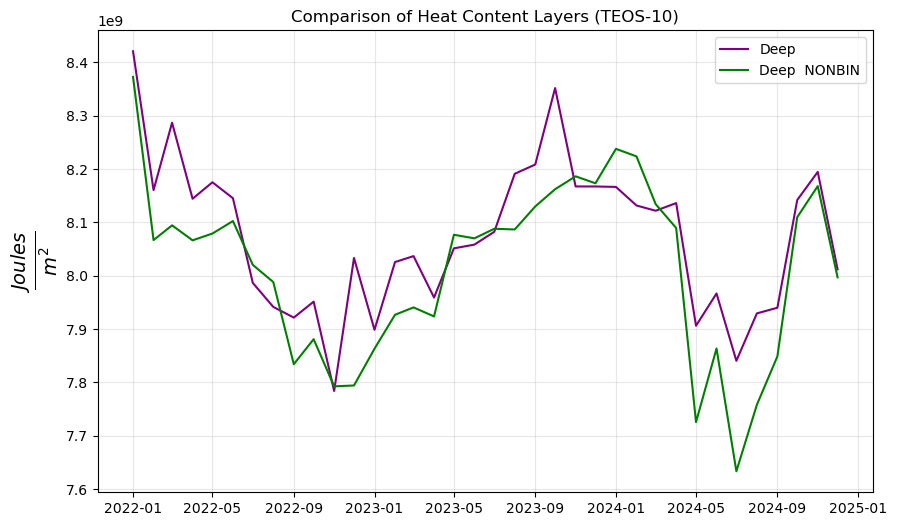

In [18]:
# Quick sanity check plot for deep, binned vs nonbinned
plt.figure(figsize=(10, 6))
#plt.plot(ts_shallow.index, ts_shallow.values, label='Shallow ', color='orange')
plt.plot(ts_deep.index, ts_deep.values, label='Deep', color='purple')
#plt.plot(ts_shallow_NONBIN.index, ts_shallow_NONBIN.values, label='Shallow  NONBIN', color='red')
plt.plot(ts_deep_NONBIN.index, ts_deep_NONBIN.values, label='Deep  NONBIN', color='green')
plt.title("Comparison of Heat Content Layers (TEOS-10)")
plt.ylabel(r"$\frac{Joules}{m^2}$", fontsize=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

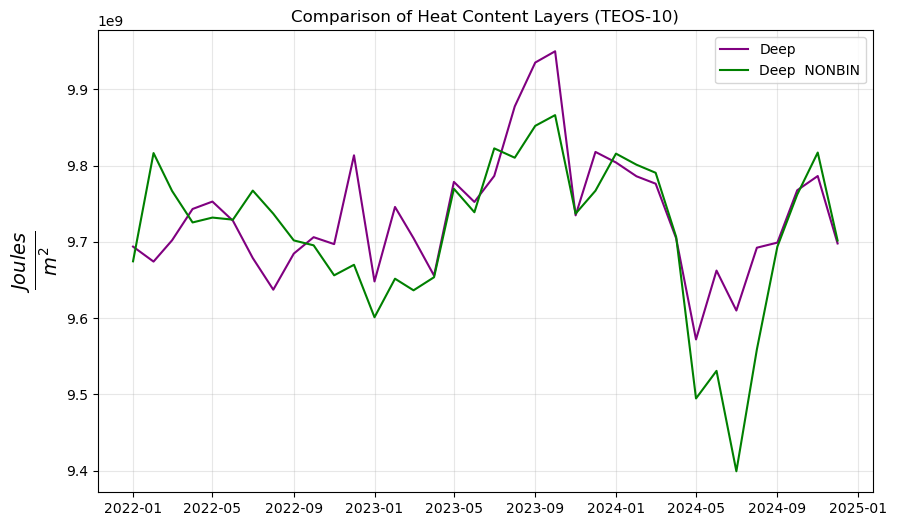

In [19]:
# Quick sanity check plot for deep, binned vs nonbinned
plt.figure(figsize=(10, 6))
#plt.plot(ts_shallow.index, ts_shallow.values, label='Shallow ', color='orange')
plt.plot(ts_background.index, ts_background.values, label='Deep', color='purple')
#plt.plot(ts_shallow_NONBIN.index, ts_shallow_NONBIN.values, label='Shallow  NONBIN', color='red')
plt.plot(ts_background_NONBIN.index, ts_background_NONBIN.values, label='Deep  NONBIN', color='green')
plt.title("Comparison of Heat Content Layers (TEOS-10)")
plt.ylabel(r"$\frac{Joules}{m^2}$", fontsize=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
final_ds

<xarray.Dataset> Size: 1MB
Dimensions:            (N_PROF: 1559, PRES_INTERPOLATED: 200)
Coordinates:
    LATITUDE           (N_PROF) float64 12kB 31.44 35.36 31.39 ... 35.05 35.94
    LONGITUDE          (N_PROF) float64 12kB -125.3 -125.1 ... -122.0 -124.2
    TIME               (N_PROF) datetime64[ns] 12kB 2022-01-03T06:08:53 ... 2...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 2kB 0 5 10 15 ... 985 990 995
  * N_PROF             (N_PROF) int64 12kB 32 1369 419 549 ... 1141 31 1039 1200
Data variables:
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 1MB 16.49 ... 3.774
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           avik2007
    Fetched_date:         2026/01/09
    Fetched_constraints:  [x=-126.00/-120.00; y=30.00/40.00; z=0.0/1000.0; t=...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

# TO DO - MAKE THE CALC OHC FUNCTION TELL YOU HOW MANY SENSORS ARE BIOFOULED

# WITH THE OHC THINGS - WE NEED TO DECIDE ON QUANTIFYING VARIABILITY
# GET THE FLOAT PLOTTER TO AUTOMATICALLY LABEL BY YEAR
# DECIDE BETWEEN BINNING - PLAY WITH EXCLUDING BINS WITH NOT ENOUGH FLOATS - LOOK UP HOW OTHER PEOPLE DEAL WITH SPARSE SAMPLING
# FIGURE OUT HOW TO CALCULATE ERRORS ON THE MEAN OHC - most error will definitely come from number of floats
# PHASE 3!
________________________________________________________________________________________________________________________________________

# This plot seems strange to me. Why is the decrease in OHC so late in the year? And how does it spring back up so fast?
# I want to check Argo float profiles

# What we do below is sort through the profiles in the xarray. I tried sorting through times, but something about how xarray
# and pandas datetimes work made it hard. The easier thing to do is below:

# --- STEP 1: INSPECT THE REAL DATES ---
# Let's pull the time array out entirely to see what the computer actually sees.
raw_times = final_ds['TIME'].values
print(f"First 3 raw timestamps: {raw_times[:3]}")

# Ensure they are proper Pandas Datetimes
# (This handles the conversion safely outside of xarray)
pd_times = pd.to_datetime(raw_times)

# Quick Sanity Check: Print the range
print(f"📅 Data Range: {pd_times.min()} to {pd_times.max()}")

# --- STEP 2: DEFINE THE WINDOWS ---
# Define your windows strictly
dip_start = pd.Timestamp('2024-04-01')
dip_end   = pd.Timestamp('2024-07-01')

max_start = pd.Timestamp('2023-09-01')
max_end   = pd.Timestamp('2023-12-01')

# --- STEP 3: FIND THE INDICES (The "Manual" Way) ---
# We create a Boolean array (True/False) using Pandas logic
mask_dip = (pd_times >= dip_start) & (pd_times <= dip_end)
mask_max = (pd_times >= max_start) & (pd_times <= max_end)

# We convert those True/False masks into Integer Indices (e.g., [0, 5, 12...])
# This is the "Coordinate" of the profile in the N_PROF list
indices_dip = np.where(mask_dip)[0]
indices_max = np.where(mask_max)[0]

print(f"\n🔍 Found {len(indices_dip)} profiles for the 'Dip' (Spring '24)")
print(f"🔍 Found {len(indices_max)} profiles for the 'Max' (Fall '23)")

# --- STEP 4: SLICE BY INDEX (isel) ---
# .isel (Integer Select) is 100% reliable because we are giving it exact row numbers
if len(indices_dip) > 0:
    ohc_dip_ds = final_ds.isel(N_PROF=indices_dip)
else:
    print("⚠️ Warning: No profiles found for Dip period!")

if len(indices_max) > 0:
    ohc_max_ds = final_ds.isel(N_PROF=indices_max)
else:
    print("⚠️ Warning: No profiles found for Max period!")

# --- STEP 5: VISUAL CONFIRMATION ---
# Only plot if we found data
if len(indices_dip) > 0 and len(indices_max) > 0:
    # Pick the first profile from each NEW subset
    p1 = ohc_dip_ds.isel(N_PROF=0)
    p2 = ohc_max_ds.isel(N_PROF=0)

    #print(f"\n✅ Profile 1 Date: {p1.TIME.values}")
    #print(f"✅ Profile 2 Date: {p2.TIME.values}")


# --- SECTION 7: VISUAL CHECK OF MAX AND DIP IN OHC  ---
    # Let's plot the first profile to make sure it looks like an ocean.
plt.figure(figsize=(6, 8))

# Select the first profile (isel selects by index)
for j in range(0,10):
    sample = ohc_dip_ds.isel(N_PROF=j)

    plt.plot(sample['TEMP'], sample['PRES_INTERPOLATED'], label='OHC Dip Profile ' + str(j), color = 'blue')
for i in range(0,10):
    sample2 = ohc_max_ds.isel(N_PROF=i)

    plt.plot(sample2['TEMP'], sample2['PRES_INTERPOLATED'], label='OHC Max Profile ' + str(i), color = 'red')
plt.gca().invert_yaxis() # Oceanography standard: Surface (0) is at top
plt.grid(True)
plt.title(f"Sample Profiles in Dip and Max")
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.legend()
plt.show()

# Let's make a fill_between plot


# --- STEP 1: CALCULATE STATISTICS ---
# We collapse the 'N_PROF' dimension, leaving only 'PRES_INTERPOLATED' (Depth)

# 1. For the "Dip" (Spring 2024)
dip_mean = ohc_dip_ds['TEMP'].mean(dim='N_PROF')
dip_min  = ohc_dip_ds['TEMP'].min(dim='N_PROF')
dip_max  = ohc_dip_ds['TEMP'].max(dim='N_PROF')

# 2. For the "Max" (Fall 2023)
max_mean = ohc_max_ds['TEMP'].mean(dim='N_PROF')
max_min  = ohc_max_ds['TEMP'].min(dim='N_PROF')
max_max  = ohc_max_ds['TEMP'].max(dim='N_PROF')

# --- STEP 2: VISUALIZE THE "ENVELOPES" ---
plt.figure(figsize=(5, 4))

# --- Plotting The "Dip" (Blue) ---
# Plot the Mean Line
plt.plot(dip_mean, dip_mean['PRES_INTERPOLATED'], 
         color='navy', linewidth=2, label='Spring Dip (Mean)')

# Shade the Range (Min to Max) using fill_betweenx
plt.fill_betweenx(
    y=dip_mean['PRES_INTERPOLATED'], 
    x1=dip_min, 
    x2=dip_max, 
    color='blue', alpha=0.1, label='Spring Range (Min-Max)'
)

# --- Plotting The "Max" (Red) ---
# Plot the Mean Line
plt.plot(max_mean, max_mean['PRES_INTERPOLATED'], 
         color='crimson', linewidth=2, label='Fall Max (Mean)')

# Shade the Range (Min to Max)
plt.fill_betweenx(
    y=max_mean['PRES_INTERPOLATED'], 
    x1=max_min, 
    x2=max_max, 
    color='red', alpha=0.1, label='Fall Range (Min-Max)'
)

# --- Formatting ---
plt.gca().invert_yaxis() # 0m at the top
plt.title("Comparison of Thermal Envelopes\n(Spring 2024 vs Fall 2023)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()